In [1]:
import feature_engineering as fe
import my_globals
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import os
tf.enable_eager_execution()
tf.enable_v2_behavior()
# tf.disable_eager_execution()

from preprocessing import cleaning, preprocess_pipeline
from utils import get_sub_dataset

from gensim.models import Word2Vec

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import mixed_precision

#### Disabling GPU ####
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
####


params = dict(
    N = 100000,
    random_seed = 0,
    max_features = 5000,
    sequence_length = 300,
    batch_size = 64, 
    epochs = 20, 
    train = False
)

# policy = mixed_precision.Policy(
#     'mixed_float16'
# )
# mixed_precision.set_global_policy(policy)



num_threads = os.environ.get('OMP_NUM_THREADS')
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)

if num_threads:
    session = tf.Session(config=tf.ConfigProto(
    gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
else:
    session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

config = tf.ConfigProto(device_count = {'GPU': 0})
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.1
session = tf.Session(config=config)
K.set_session(session)


In [2]:
data = get_sub_dataset(size = params["N"], random_seed=params["random_seed"])
data = cleaning(data)
data["processed_text"] = data["text"].apply(
    lambda s:
    preprocess_pipeline(
        s,
        pipeline="w2v"
    )
)

if params["train"]:
    feature_df, w2v_model = fe.word_embedding(
        data,
        vector_size=params["max_features"],
        w2v_epochs=30,
        aggregate="l3",
        colname="processed_text"
    )
else:
    w2v_model = Word2Vec.load("../project_data/w2v_model.pickle")

C:\Users\linru\AppData\Roaming\Python\Python39\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [3]:
# Split

XX = data[["processed_text"]]
yy = data[["target"]]

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    XX, yy, test_size=0.15, random_state = params["random_seed"]
)



In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_X_train["processed_text"])
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(
    tokenizer.texts_to_sequences(df_X_train["processed_text"]), 
    maxlen=params["sequence_length"]
)
X_test = pad_sequences(
    tokenizer.texts_to_sequences(df_X_test["processed_text"]), 
    maxlen=params["sequence_length"]
)

encoder = LabelEncoder()
encoder.fit(df_y_train["target"].tolist())
y_train = encoder.transform(df_y_train["target"].tolist())
y_test = encoder.transform(df_y_test["target"].tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [5]:
# Construct embedding layer

embedding_matrix = np.zeros((vocab_size, params["max_features"]))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

with tf.device('cpu:0'):
  embedding_layer = Embedding(
    vocab_size, 
    params["max_features"],
    weights=[embedding_matrix], 
    input_length=params["sequence_length"], 
    trainable=False
  )
  embedding_layer.build(input_shape=params["sequence_length"])

(46715, 5000)


In [6]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 5000)         233575000 
                                                                 
 dropout (Dropout)           (None, 300, 5000)         0         
                                                                 
 lstm (LSTM)                 (None, 100)               2040400   
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 235,615,501
Trainable params: 2,040,501
Non-trainable params: 233,575,000
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

callbacks = [
    # ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]

In [10]:
history = model.fit(X_train, y_train,
                    batch_size=params["batch_size"],
                    epochs=params["epochs"],
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/20
1196/1196 [==============================] - 7456s 6s/step - loss: 0.4076 - accuracy: 0.8089 - val_loss: 0.4905 - val_accuracy: 0.7709
Epoch 2/20
1196/1196 [==============================] - 7491s 6s/step - loss: 0.3862 - accuracy: 0.8211 - val_loss: 0.5015 - val_accuracy: 0.7676
Epoch 3/20
1196/1196 [==============================] - 7421s 6s/step - loss: 0.3690 - accuracy: 0.8310 - val_loss: 0.5173 - val_accuracy: 0.7626
Epoch 4/20
1196/1196 [==============================] - 7636s 6s/step - loss: 0.3495 - accuracy: 0.8410 - val_loss: 0.5203 - val_accuracy: 0.7673
Epoch 5/20
1196/1196 [==============================] - 7798s 7s/step - loss: 0.3302 - accuracy: 0.8498 - val_loss: 0.5582 - val_accuracy: 0.7627
Epoch 6/20
1196/1196 [==============================] - 7127s 6s/step - loss: 0.3141 - accuracy: 0.8600 - val_loss: 0.5683 - val_accuracy: 0.7606


In [11]:
y_pred = model.predict(X_test)

469/469 [==============================] - 527s 1s/step


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def assess(y_true, y_pred):
    print("confusion matrix:")
    conf_mat = confusion_matrix(y_true, y_pred)
    print(conf_mat)
    print()
    print("accuracy_score:")
    print(accuracy_score(y_true, y_pred))
    print()
    print("classification report:")
    print(classification_report(y_true,y_pred))
    print()
    return conf_mat

In [18]:
y_pred = (y_pred >= 0.5) * 1

Out of sample assessment:

confusion matrix:
[[5552 1935]
 [1723 5790]]

accuracy_score:
0.7561333333333333

classification report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      7487
           1       0.75      0.77      0.76      7513

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000




<AxesSubplot: >

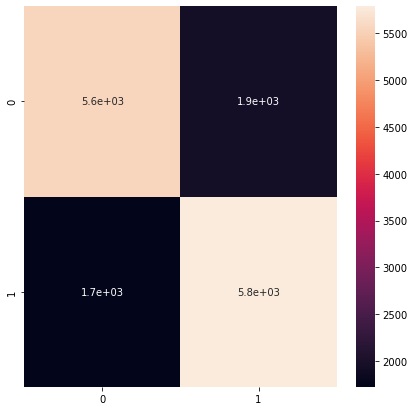

In [19]:
print("Out of sample assessment:")
print()
conf_mat = assess(y_test, y_pred)

fig, ax = plt.subplots(1,1, figsize = [7,7])
sns.heatmap(conf_mat, annot=True, ax = ax)